# Mews SRE Task

## Initial exploration

In [3]:
# Some imports for the future
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,3) # so we get some nice wide plots
import numpy as np

First, let's start looking at how the data is structured.

In [4]:
logs = pd.read_json("./logs.txt", lines=True)

logs.head()

,TimeStamp,Endpoint,StatusCode,Duration
0,2021-08-26 13:00:00.000,/api/reservations/add,200,471
1,2021-08-26 13:00:00.064,/api/reservations/add,200,511
2,2021-08-26 13:00:00.115,/api/reservations/add,200,523
3,2021-08-26 13:00:00.258,/api/reservations/add,200,537
4,2021-08-26 13:00:00.349,/api/reservations/add,200,485


Let's verify that all the data has been cast to the right format automatically

In [5]:
logs.dtypes

TimeStamp     datetime64[ns]
Endpoint              object
StatusCode             int64
Duration               int64
dtype: object

Looks good.

Let's take a look at all the endpoints in the logs, just to get an overview of what we are dealing with.

In [6]:
logs["Endpoint"].unique()

array(['/api/reservations/add', '/api/reservations/get',
       '/api/reservations/cancel', '/api/reservations/update',
       '/api/rates/add', '/api/rates/update', '/api/rates/delete'],
      dtype=object)

Also, as an overview, let's look if we have any endpoint returning anything that is not 200.

In [7]:
logs[logs["StatusCode"] != 200]

,TimeStamp,Endpoint,StatusCode,Duration


All the logs return a status code of 200, the system was always operational.

## Looking at the endpoints

Since the task mentions that at some point for some endpoints, response time might be impacted, let's see if we can visually identify endpoints which had slowdowns, just by looking at a plot which for each event, plots the duration. 

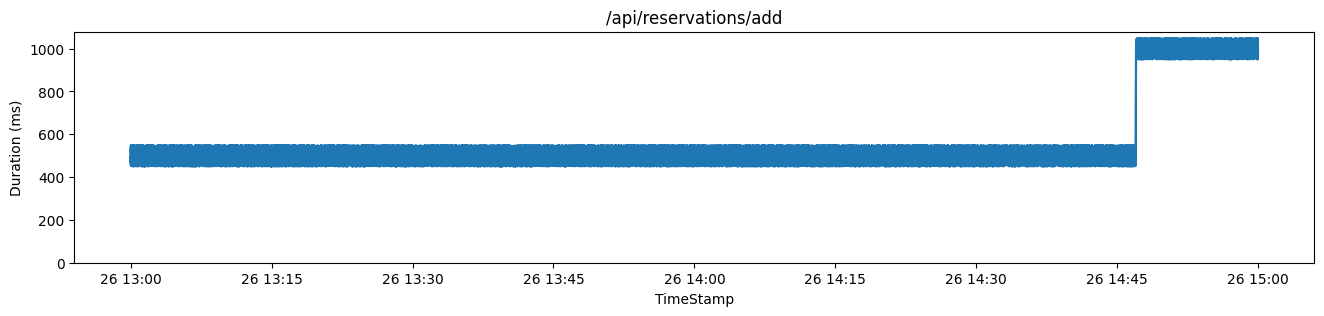

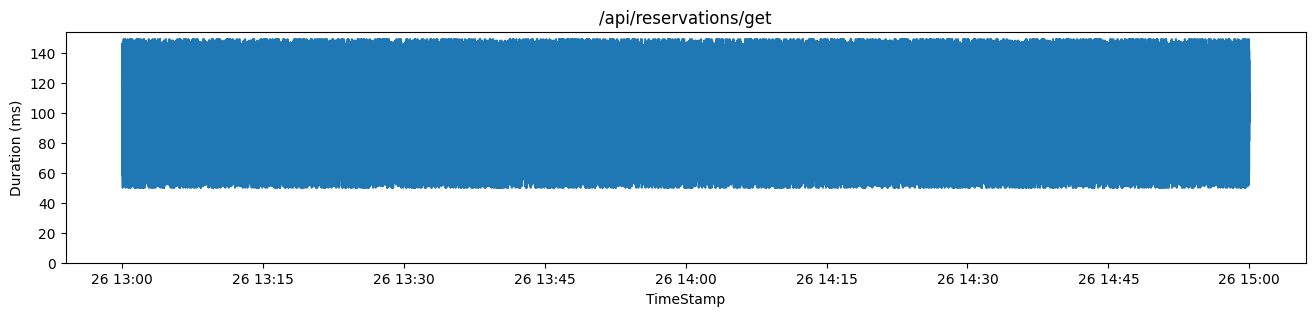

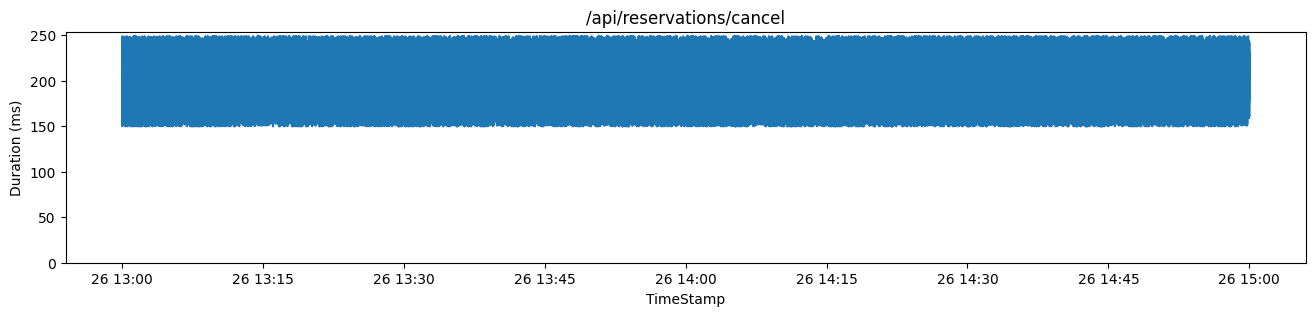

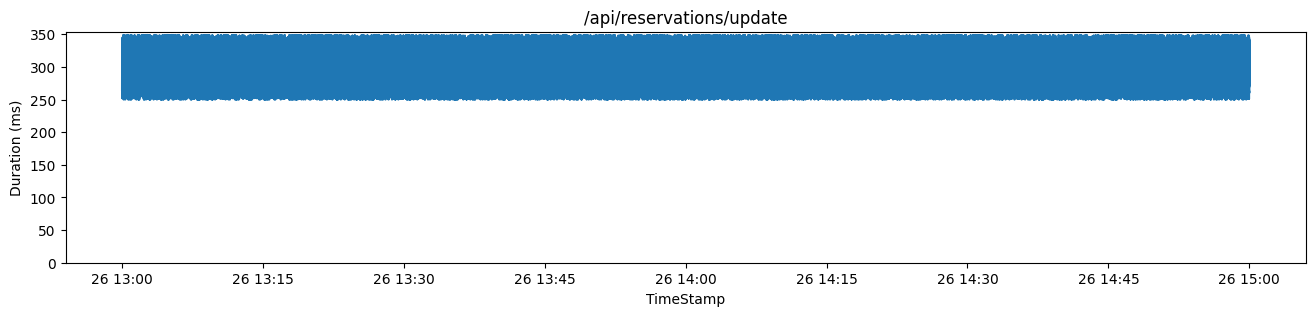

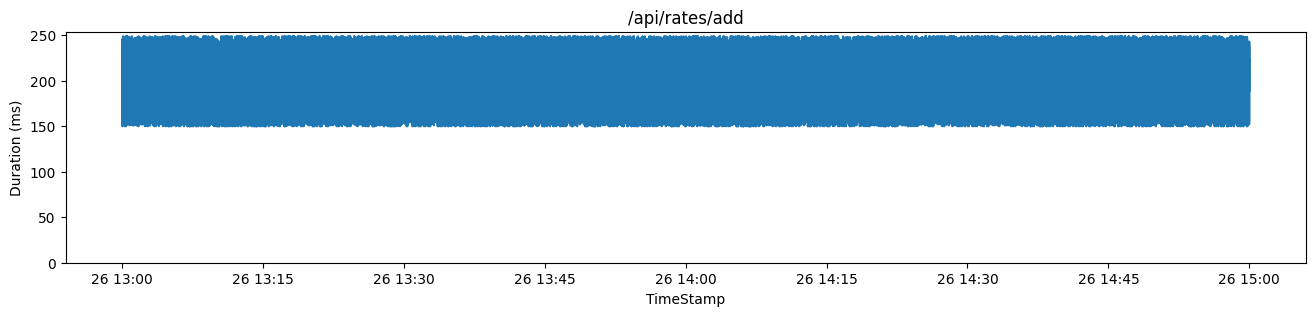

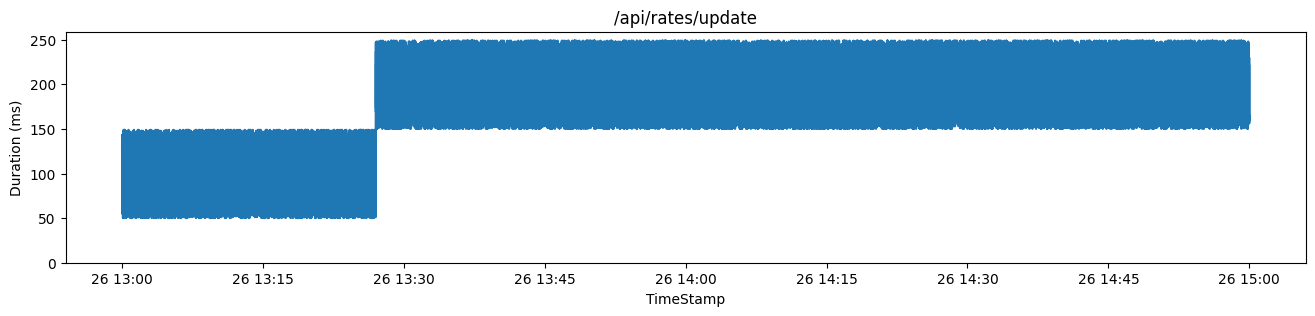

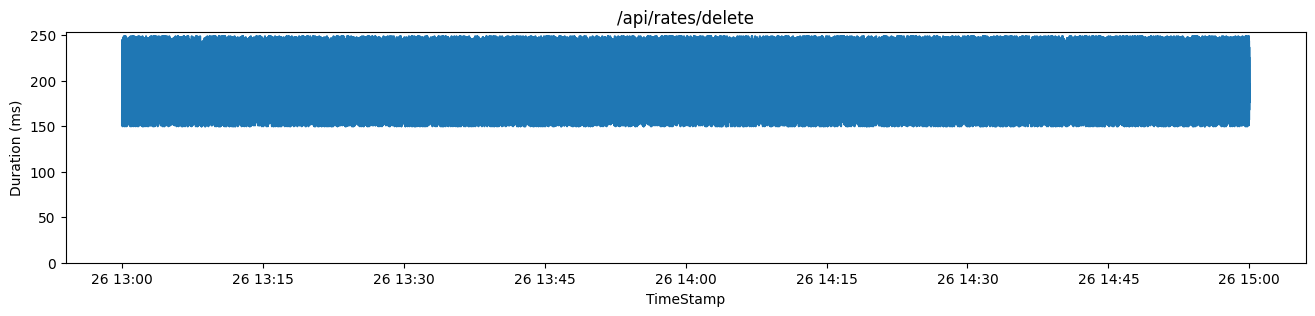

In [8]:
for endpoint in logs["Endpoint"].unique():
    endpoint_logs = logs[logs["Endpoint"] == endpoint]
    plt.plot(endpoint_logs["TimeStamp"], endpoint_logs["Duration"])
    plt.title(endpoint)
    plt.xlabel("TimeStamp")
    plt.ylabel("Duration (ms)")
    plt.ylim(ymin=0) # so we have 0ms as a baseline for the plot
    plt.show()

The plots are a bit noisy, there are a lot of data points to consider. But still we can visually identify a slowdown for the endpoints `/api/reservations/add` and `/api/rates/updates` at some point in the time series.

All the other endpoints appear to be fine, at least visually, with some sistematic fluctuations that are observable. 

Clarity of the plots could be improved by reducing the data points, by averaging/bucketing timestamps close to each other (for example by averaging out requests in buckets of 5 minutes). I am not doing this since it is not particularly useful now. 

## The definition of "regression"

Since we are working with very loose specifications on the definition of regression (slowdown), we can think a bit on which meaning we want to give to this word.

### Maximum duration

One possible definition of "slowdown" would be one that checks based on some endpoint duration "budget". It is possible that, in some use cases, each endpoint must respond within a certain timeframe/must have a maximum latency, otherwise the service can be considered distrupted. For example one can have an agreement that speecifies "all endpoints must give an answer in maximum 1s". If that was the case, it would mean that finding regressing endpoints (and when they started regressing) would be quite trivial, as follows:

In [16]:
MAXIMUM_DURATION = 1000 # ms
logs[logs["Duration"] > MAXIMUM_DURATION].groupby("Endpoint").first() # selects the first log that regresses for each endpoint

,TimeStamp,StatusCode,Duration
Endpoint,,,
/api/reservations/add,2021-08-26 14:47:00.248,200,1011


We can see that the only endpoint that "regresses" given our definition of "answer in maximum 1 second" is just `/api/reservations/add`, which regresses at `2021-08-26 14:47:00.248`. 

By having different `MAXIMUM_DURATION` per endpoint, we can adapt to the fact that endpoints might have different latency "budgets". 

In [29]:
MAXIMUM_DURATIONS = {
    "/api/reservations/add": 1000,
    "/api/rates/update": 200,
}

for endpoint in logs["Endpoint"].unique():
    endpoint_logs = logs[logs["Endpoint"] == endpoint]
    TARGET_DURATION = MAXIMUM_DURATIONS.get(endpoint, 1000) # if a value is not set for this particular endpoint, use 1s
    slow_endpoint_logs = endpoint_logs[endpoint_logs["Duration"] > TARGET_DURATION] # get all log lones which are over the TARGET_DURATION
    if len(slow_endpoint_logs) > 1:
        print(f"{endpoint}: {len(slow_endpoint_logs)} requests went over the target of {TARGET_DURATION}ms")
        print(f"{endpoint}: first regressing request: {slow_endpoint_logs.iloc[0]['TimeStamp']}")

/api/reservations/add: 3166 requests went over the target of 1000ms
/api/reservations/add: first regressing request: 2021-08-26 14:47:00.248000
/api/rates/update: 21956 requests went over the target of 200ms
/api/rates/update: first regressing request: 2021-08-26 13:27:00.309000


Of course this logic is not always applicable for all business use cases. 
If you have no business-specified maximum endpoint response time, you could try to set an arbitrarly high maximum duration, but slowdown not considered "high enough" would be missed and service could still be impacted.

### Adaptive solution

We can also write a solution which is not based on arbitrary numbers, but a solution which adapts to each endpoint automatically. 

The intuition is simple, if we see and endpoint "misbehaving" from the "usual", then it must be regressing. But how do we define this "usual" and "misbehaving"?